## Introduction

This notebook describes the analysis of extracellular recording data from Loren Frank Lab. The data was downloaded from CRNS website ( https://portal.nersc.gov/project/crcns/download/hc-6 ). These are tetrode recordings from the medial Entorhinal Corectex (mEC) and hippocampus of male rats. I have plans to understand coherence in certain freequency intervals from the LFP traces and we will look into spiking of units/cells related to spatial aspects of the experiments and temporal aspects of the Local Field Potential (LFP) recordings.  I have plan to uncover the reduced dimensional representations using some embedding methods (locally linear embeddings, autoencoders, etc.)

In [49]:
import numpy as np
from numpy.fft import rfft
import scipy.io
from scipy import signal
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
from neurodsp.filt import filter_signal

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

On the 9th day, 4th block (rat was on one of the two w-sized tracks) of the experiments, the rat named Five was alternating between the two branch legs of the track to get a reward. 

In [5]:
pos = np.genfromtxt("g:/Arun/neural_data/hc-6/Fiv/processed_data/FivePos09_04.csv", delimiter=",")

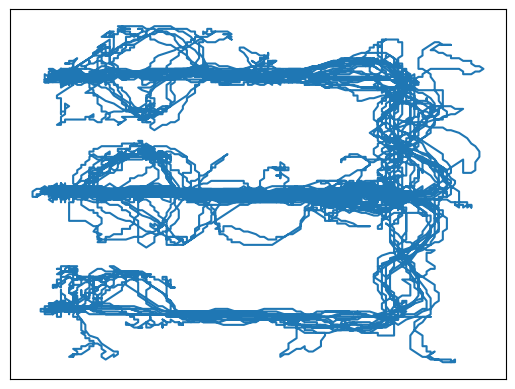

In [50]:
fig = plt.figure()
plt.plot(pos[:,1], pos[:,2])
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Major features of LFP
Peaks at Theta and gamma oscillation frequencies (Not pronouced in this LFP traces) in 
the spectrogram

In [10]:
def plot_spectrum_lfp(day, epoch):
    fname = "g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg0{}-{}-01.mat".format(day, epoch)
    print(fname)
    dat_all = scipy.io.loadmat(fname, squeeze_me=True, chars_as_strings=True)
    # print(dat_all.keys())
    eeg = dat_all['eeg'][-1][-1]
    print(eeg)
    eeg = eeg.tolist()
    print(eeg[4])
    start_time = eeg[2]
    sampling_rate = eeg[3]
    end_time = start_time+len(eeg)*(1/sampling_rate)
    T = end_time-start_time
    
    eeg = np.asarray(eeg[4])
    tim = np.linspace(start_time, end_time,len(eeg))

    dt = 1/sampling_rate
    df = 1/T

    print("dt: ", dt)
    print("df: ", df)
    
    sig = eeg-eeg.mean()
    # Mean of spectrogram (Welch)
    freq_mean, psd_mean = compute_spectrum(sig, sampling_rate, method='welch', avg_type='mean', nperseg=sampling_rate*2)

    # Median of spectrogram ("median Welch")
    freq_med, psd_med = compute_spectrum(sig, sampling_rate, method='welch', avg_type='median', nperseg=sampling_rate*2)

    # Median filtered spectrum
    freq_mf, psd_mf = compute_spectrum(sig, sampling_rate, method='medfilt')


    # Plot the power spectra
    plot_power_spectra([freq_mean[:200], freq_med[:200], freq_mf[100:10000]],
                   [psd_mean[:200], psd_med[:200], psd_mf[100:10000]],
                   ['Welch', 'Median Welch', 'Median Filter FFT'])

    

g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg09-4-01.mat
('eeg data from 01-168.eeg: 01:01:25 to 01:16:30\n', 'eegamplitude', 3684.9968, 1500.0001104956175, array([-82, -77, -70, ..., 299, 293, 279], dtype=int16), 168)
[-82 -77 -70 ... 299 293 279]
dt:  0.000666666617557507
df:  250.0000184231808


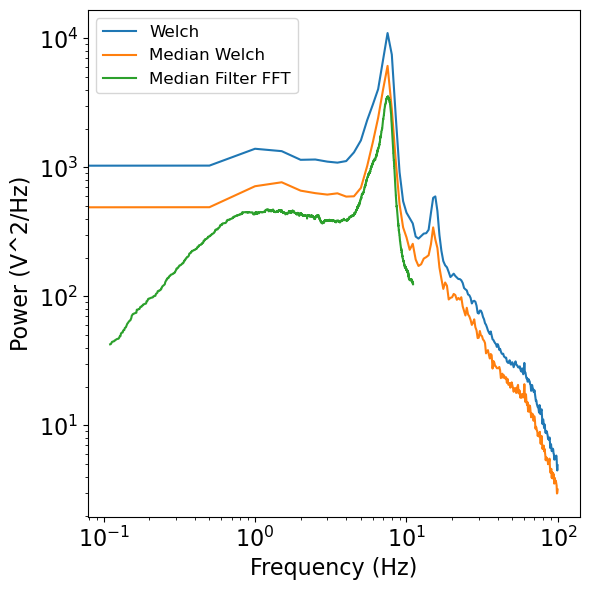

In [51]:
plot_spectrum_lfp(9,4)

## LFP with 5-15 Hz bandpassed trace

In [56]:
def plot_filtered_theta_with_lfp(day, epoch):
    fname = "g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg0{}-{}-01.mat".format(day, epoch)
    print(fname)
    dat_all = scipy.io.loadmat(fname, squeeze_me=True, chars_as_strings=True)
    # print(dat_all.keys())
    eeg = dat_all['eeg'][-1][-1]
    print(eeg)
    eeg = eeg.tolist()
    print(eeg[4])
    start_time = eeg[2]
    sampling_rate = eeg[3]
    end_time = start_time+len(eeg)*(1/sampling_rate)
    T = end_time-start_time
    
    eeg = np.asarray(eeg[4])
    tim = np.linspace(start_time, end_time,len(eeg))

    dt = 1/sampling_rate
    df = 1/T

    print("dt: ", dt)
    print("df: ", df)
    
    sig = eeg-eeg.mean()


    fNQ = 1 / dt / 2

    Wn = [5,15]
    n = 100
    b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
    Vlo = signal.filtfilt(b, 1, sig);
    phi = np.angle(signal.hilbert(Vlo))


    fig, ax1 = plt.subplots(figsize=(18,6))
    
    ax1.plot(tim[:], eeg[:],'k')
    ax1.plot(tim[:], Vlo,'r')
    ax1.set_xlim([3684.99924, 3684.99926])
    ax1.set_ylim([-500,500])
    ax1.set_ylabel("LFP (mV)")
    ax1.set_xlabel("Time (seconds)")
    plt.show()

g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg09-4-01.mat
('eeg data from 01-168.eeg: 01:01:25 to 01:16:30\n', 'eegamplitude', 3684.9968, 1500.0001104956175, array([-82, -77, -70, ..., 299, 293, 279], dtype=int16), 168)
[-82 -77 -70 ... 299 293 279]
dt:  0.000666666617557507
df:  250.0000184231808


C:\Users\Acer\AppData\Local\Temp\ipykernel_22872\1597638461.py:31: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');


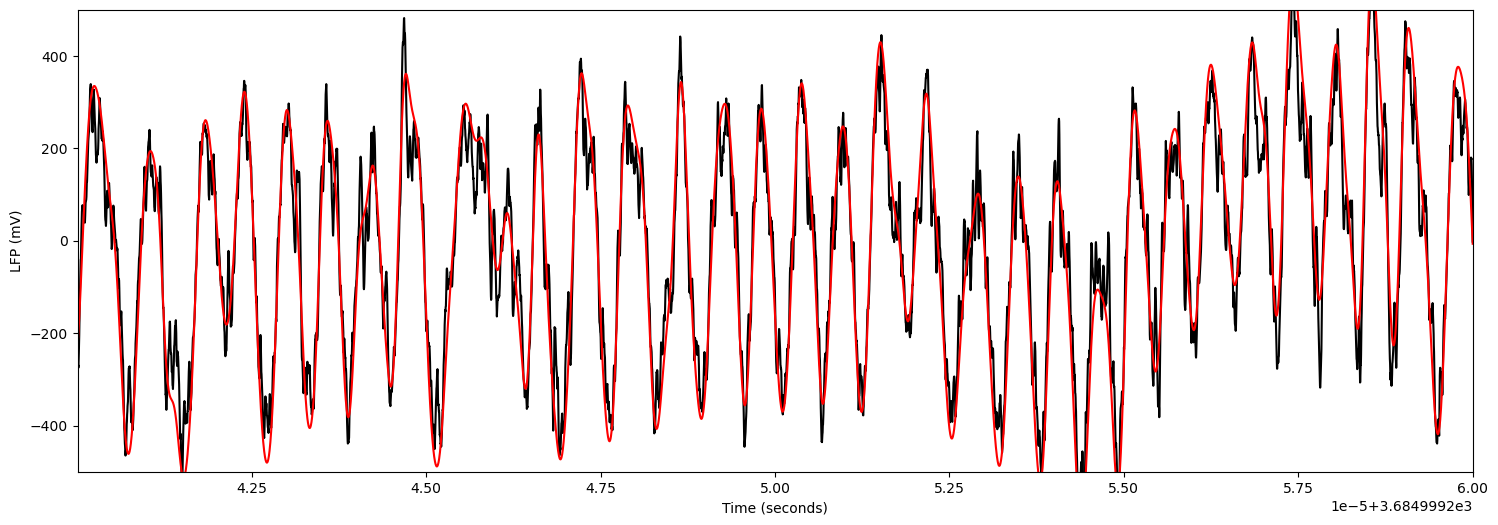

In [57]:
plot_filtered_theta_with_lfp(9,4)

g:/Arun/neural_data/hc-6/Fiv/Fivspikes09.mat


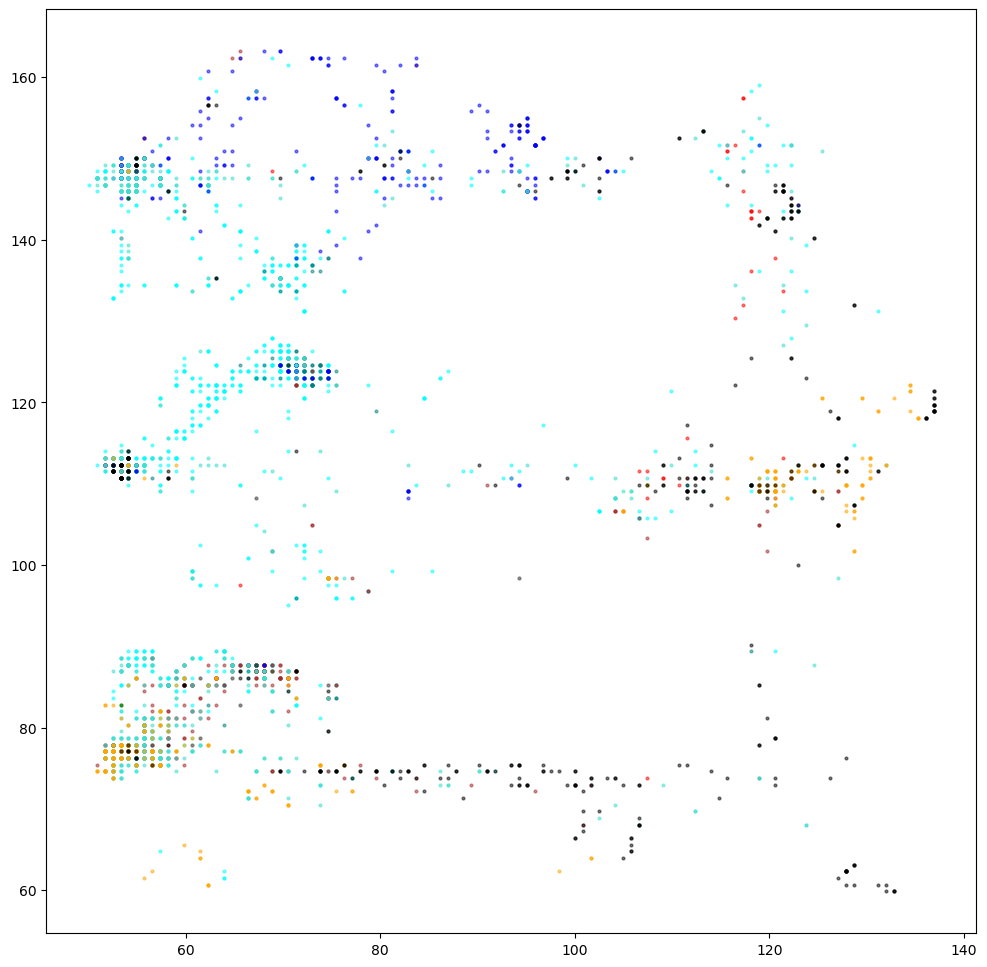

In [82]:

file_list = ["g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_7-1.csv", 
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-1.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-2.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-3.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-4.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-2.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-3.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-4.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-5.csv"]

colors = ["red","cyan","teal","green","brown","blue","turquoise","orange","black"]

plt.figure(figsize=(12,12))
for iter,fname in enumerate(file_list):
    spiketimes = np.genfromtxt(fname, delimiter=",")
    plt.scatter(spiketimes[:,1],spiketimes[:,2],c=colors[iter],s=4,alpha=0.5)



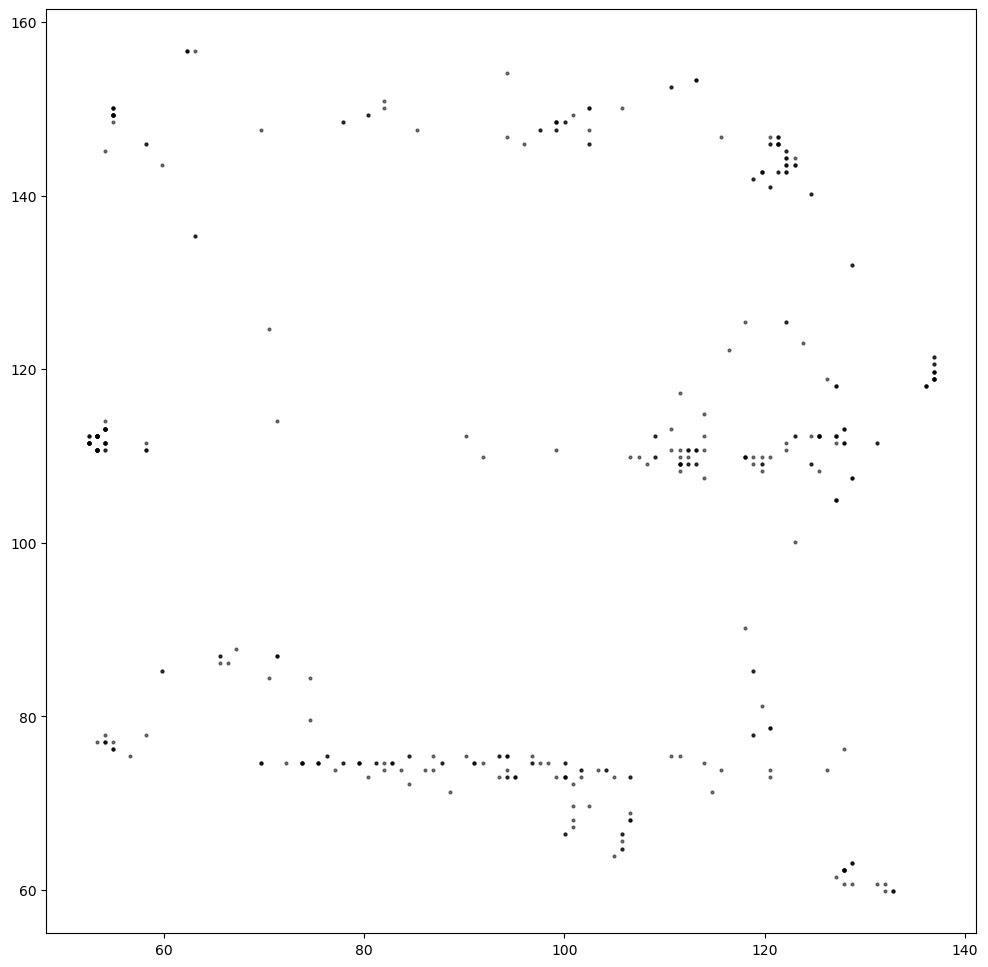

In [83]:
plt.figure(figsize=(12,12))
fname = file_list[-1]
spiketimes = np.genfromtxt(fname, delimiter=",")
plt.scatter(spiketimes[:,1],spiketimes[:,2],c="k",s=4,alpha=0.5)

In [85]:
spiketimes[:,0].min(), spiketimes[:,0].max()

(3717.6663, 4586.1397)

In [87]:
def plot_heatmap_phase(day, epoch):
    fname = "g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg0{}-{}-01.mat".format(day, epoch)
    print(fname)
    dat_all = scipy.io.loadmat(fname, squeeze_me=True, chars_as_strings=True)
    # print(dat_all.keys())
    eeg = dat_all['eeg'][-1][-1]
    print(eeg)
    eeg = eeg.tolist()
    print(eeg[4])
    start_time = eeg[2]
    sampling_rate = eeg[3]
    end_time = start_time+len(eeg)*(1/sampling_rate)
    T = end_time-start_time
    
    eeg = np.asarray(eeg[4])
    tim = np.linspace(start_time, end_time,len(eeg))

    dt = 1/sampling_rate
    df = 1/T

    print("dt: ", dt)
    print("df: ", df)
    
    sig = eeg-eeg.mean()


    fNQ = 1 / dt / 2

    Wn = [5,15]
    n = 100
    b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
    Vlo = signal.filtfilt(b, 1, sig);
    phi = np.angle(signal.hilbert(Vlo))


    return start_time, end_time

In [88]:
plot_heatmap_phase(9,4)

g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg09-4-01.mat
('eeg data from 01-168.eeg: 01:01:25 to 01:16:30\n', 'eegamplitude', 3684.9968, 1500.0001104956175, array([-82, -77, -70, ..., 299, 293, 279], dtype=int16), 168)
[-82 -77 -70 ... 299 293 279]
dt:  0.000666666617557507
df:  250.0000184231808


C:\Users\Acer\AppData\Local\Temp\ipykernel_22872\3021807901.py:31: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');


(3684.9968, 3685.000799999705)

## Immediate plans
We will collect all the units/cells whose spikes are recorded in the dataset. We would like to know
1) What is the proportion of spatially modulated cells? are there any overrepresentation of particular places from the w-track?
2) If we can bin the locations where the spiking of cells were modulated by the theta rhythm (or gamma) will they cover the track uniformly? or will there be places where the spike-coherence is largest?  